In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from tqdm.autonotebook import tqdm
from torch.optim.lr_scheduler import StepLR
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

# Read in Data

In [50]:
train = pd.read_csv('/content/drive/My Drive/ML/FDA/HW3/data/Shopping/online_shoppers_intention.csv')

device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda:0'
print(device)

cuda:0


In [0]:
train_d = train.drop(['Informational',
       'Informational_Duration','TrafficType','OperatingSystems', 'Browser', 'Region'],axis=1)
train_d['Weekend'] = train_d['Weekend'].apply(lambda x : 1 if x== True else 0)
train_d['Revenue'] = train_d['Revenue'].apply(lambda x : 1 if x== True else 0)

# Visualization

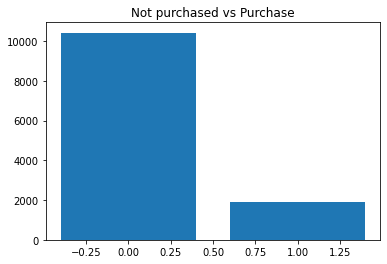

In [52]:
tmp = train['Revenue'].value_counts()
plt.bar(tmp.index,tmp.values)
plt.title('Not purchased vs Purchase')
plt.show()

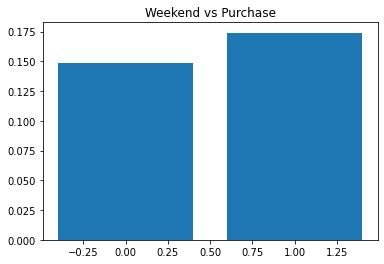

In [53]:
weekend = train_d.groupby('Weekend').describe()
plt.bar(weekend.index,weekend['Revenue']['mean'])
plt.title('Weekend vs Purchase')
plt.show()

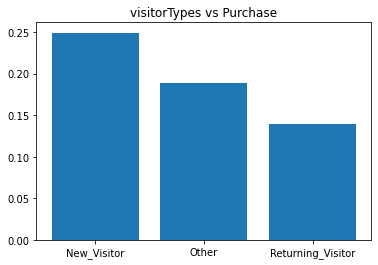

In [54]:
visitor = train_d.groupby('VisitorType').describe()
plt.bar(visitor.index,visitor['Revenue']['mean'])
plt.title('visitorTypes vs Purchase')
plt.show()

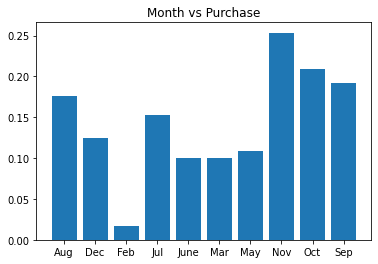

In [8]:
month = train_d.groupby('Month').describe()
plt.bar(month.index,month['Revenue']['mean'])
plt.title('Month vs Purchase')
plt.show()

# Preprocess

In [0]:
# cathegorical encoding
all_dum = pd.get_dummies(train_d, columns=['VisitorType', 'Month','Revenue'])

#split data test / train
split_num = int(np.round(train_d.shape[0]*0.85))
all_dum = shuffle(all_dum)
train_dum = all_dum[:split_num]
test_dum = all_dum[split_num:]


In [56]:
# Oversampling test data
new = (train_dum[train_dum['Revenue_1']==1])
train_aug = train_dum.append([new]*5,ignore_index=True)
train_aug.shape

(18745, 24)

In [0]:
# getting rid of outliers
train_aug = train_aug[train_aug['Administrative_Duration']<250]
train_aug = train_aug[train_aug['ProductRelated_Duration']<3600]
train_aug = train_aug[train_aug['ProductRelated']<100]
train_aug = train_aug[train_aug['Administrative']<10]

In [15]:
# normalize
def scaling(d1,d2,features):
  x1 = d1
  x2 = d2
  for fea in features:
    scaler = MinMaxScaler(feature_range=(0,1))
    x1[fea] = scaler.fit_transform(x1[fea].values.reshape(-1,1))
    x2[fea] = scaler.transform(x2[fea].values.reshape(-1,1))
  return [x1,x2]
features = ['Administrative','Administrative_Duration','ProductRelated','ProductRelated_Duration','PageValues']
train_aug , test_dum = scaling(train_aug,test_dum,features)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [0]:
train_aug = shuffle(train_aug)
def load_data(df):
  y = df[['Revenue_0','Revenue_1']].values
  x = df.drop(['Revenue_0','Revenue_1'],axis = 1).values
  # split test / train set
  i = int(np.round(x.shape[0]*0.9))
  x_train = x[:i,:]
  y_train = y[:i]
  x_test = x[i:,:]
  y_test = y[i:]
  return [np.array(x_train),np.array(y_train),np.array(x_test),np.array(y_test)]

x_train, y_train, x_test, y_test = load_data(train_aug)

x_train = torch.from_numpy(x_train).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)

x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

train_ld = torch.utils.data.TensorDataset(x_train,y_train)
test_ld = torch.utils.data.TensorDataset(x_test, y_test)



In [20]:
x_train.shape , y_train.shape , x_test.shape , y_test.shape

(torch.Size([13276, 22]),
 torch.Size([13276, 2]),
 torch.Size([1475, 22]),
 torch.Size([1475, 2]))

# Training

In [0]:
class MLP(nn.Module):
  def __init__(self,input_dim):
    super(MLP,self).__init__()
    self.input_dim = input_dim
    self.fc1 = nn.Linear(input_dim,64,bias=True)
    self.fc2 = nn.Linear(64,128,bias=True)
    # self.fc3 = nn.Linear(128,128,bias=True)
    self.fc4 = nn.Linear(128,256,bias=True)
    self.fc5 = nn.Linear(256,128,bias=True)
    self.fc6 = nn.Linear(128,128,bias=True)
    self.out = nn.Linear(128,2,bias=True)

  def forward(self,x):
    x = F.relu(self.fc1(x))
    x = F.dropout(x, p=0.5, training=self.training)
    x = F.relu(self.fc2(x))
    x = F.dropout(x, p=0.5, training=self.training)
    # x = F.relu(self.fc3(x))
    # x = F.dropout(x, p=0.5, training=self.training)
    x = F.relu(self.fc4(x))
    x = F.dropout(x, p=0.5, training=self.training)
    x = F.relu(self.fc5(x))
    x = F.dropout(x, p=0.8, training=self.training)
    x = F.relu(self.fc6(x))
    out = F.softmax(self.out(x),dim =1)
    return out

In [37]:
batch_size = 512
train_loader = DataLoader(train_ld, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ld, batch_size=batch_size, shuffle=False)

model = MLP(22).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCEWithLogitsLoss()
# scheduler = StepLR(optimizer, step_size=50, gamma=0.5) #learning rate decrease while training

def init_weights(m):#weight initialization
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
model.apply(init_weights)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  del sys.path[0]


MLP(
  (fc1): Linear(in_features=22, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=2, bias=True)
)

In [38]:
epochs = 500
hist = []
for epoch in tqdm(range(epochs), desc="Epochs"):
  running_loss = []
  for data, label in train_loader:
    data = data.to(device)
    # label = label.to(device)
    label = torch.tensor(label, dtype=torch.long, device=device)
    optimizer.zero_grad()

    output = model.forward(data)

    loss = criterion(output,label.type_as(output))
    # print(torch.max(label, 1)[1])
    loss.backward()
    optimizer.step()
    # scheduler.step()
    # print(loss)
    running_loss.append(loss.item())
  print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, np.mean(running_loss)))
  hist.append(np.mean(running_loss))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Epoch: 1/500 - Loss: 0.7247
Epoch: 2/500 - Loss: 0.7210
Epoch: 3/500 - Loss: 0.7148
Epoch: 4/500 - Loss: 0.7008
Epoch: 5/500 - Loss: 0.6848
Epoch: 6/500 - Loss: 0.6772
Epoch: 7/500 - Loss: 0.6730
Epoch: 8/500 - Loss: 0.6678
Epoch: 9/500 - Loss: 0.6662
Epoch: 10/500 - Loss: 0.6633
Epoch: 11/500 - Loss: 0.6615
Epoch: 12/500 - Loss: 0.6596
Epoch: 13/500 - Loss: 0.6581
Epoch: 14/500 - Loss: 0.6561
Epoch: 15/500 - Loss: 0.6515
Epoch: 16/500 - Loss: 0.6508
Epoch: 17/500 - Loss: 0.6465
Epoch: 18/500 - Loss: 0.6431
Epoch: 19/500 - Loss: 0.6405
Epoch: 20/500 - Loss: 0.6376
Epoch: 21/500 - Loss: 0.6381
Epoch: 22/500 - Loss: 0.6364
Epoch: 23/500 - Loss: 0.6306
Epoch: 24/500 - Loss: 0.6318
Epoch: 25/500 - Loss: 0.6308
Epoch: 26/500 - Loss: 0.6265
Epoch: 27/500 - Loss: 0.6249
Epoch: 28/500 - Loss: 0.6226
Epoch: 29/500 - Loss: 0.6220
Epoch: 30/500 - Loss: 0.6191
Epoch: 31/500 - Loss: 0.6161
Epoch: 32/500 - Loss: 0.6154
Epoch: 33/500 - Loss: 0.6146
Epoch: 34/500 - Loss: 0.6116
Epoch: 35/500 - Loss: 0

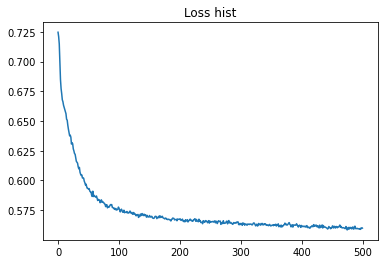

In [39]:
plt.plot(hist)
plt.title('Loss hist')
plt.show()

In [40]:
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for data,labels in test_loader:
        data = data.to(device)
        labels = labels.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        _, true_labels = torch.max(labels.data, 1)
        total += labels.size(0)
        correct += (predicted == true_labels).sum().item()
print(correct)
print(total)
print('Accuracy of the network on the test data: %d %%' % (
    100 * correct / total))

1295
1475
Accuracy of the network on the test data: 87 %


In [0]:
def load_test(df):
  y = df[['Revenue_0','Revenue_1']].values
  x = df.drop(['Revenue_0','Revenue_1'],axis = 1).values
  return [np.array(x),np.array(y)]

x_val, y_val = load_test(test_dum)

x_val = torch.from_numpy(x_val).type(torch.Tensor)
y_val = torch.from_numpy(y_val).type(torch.Tensor)
val_ld = torch.utils.data.TensorDataset(x_val, y_val)
val_loader = DataLoader(val_ld, batch_size=batch_size, shuffle=False)


In [44]:
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for data,labels in val_loader:
        data = data.to(device)
        labels = labels.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        _, true_labels = torch.max(labels.data, 1)
        total += labels.size(0)
        # print(predicted)
        # print(true_labels)
        # break

        correct += (predicted == true_labels).sum().item()
print(correct)
print(total)
print('Accuracy of the network on the test data: %d %%' % (
    100 * correct / total))

1576
1850
Accuracy of the network on the test data: 85 %


In [0]:
# torch.save(model.state_dict(), '/content/drive/My Drive/ML/FDA/HW3/3-2/shoping_test_acc_best')